<a href="https://colab.research.google.com/github/duwcston/Image-Classification-Using-Pets-Dataset/blob/main/Image_Classification_on_Oxford_IIIT_Pets_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning for Multi-Class Image Classification

### Image classification of Oxford-IIIT Pets dataset using these model:
- ResNet50 V2
- CNN
- Inception V3
- MobileNet V2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

## (1) Initial Setup
- Highly recommended to run this notebook in Google Colab
- All the essential Python libraries we need for this project are already pre-installed in the default Google Colab environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.python.keras.layers import Dense
from keras import callbacks

In [ ]:
# Check Tensorflow version
tf. __version__

'2.15.0'

In [ ]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

classifier_model = {'mobilenet_v2':mobilenet_v2, 'inception_v3':inception_v3,'resnset50':resnset50}

___
## (2) Import Data
- For this project, we will be working with the Oxford-IIIT dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/)
- The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.
- While there are various sources where the image dataset can be downloaded from, we will use the `tfds` module to load the images.
- `tfds` stands for Tensorflow Datasets, and it is a Tensorflow component that defines a collection of datasets ready-to-use with TensorFlow

#### Load and split the raw image data
- We load the pets dataset (named as `oxford_iiit_pet` in `tfds`) as a `tf.data.Dataset` object, and the raw dataset has two sets: train and test
- For our project, we want to split the dataset into three sets: train set, validation set, and test set.
- The train/val split is set as 90:10 ratio, and we also ensure the images are shuffled
- We can use percentages (%) to slice the datasets, so that there is no need for us to input the exact index for splitting
- Note that when we set the parameter `with_info=True`, we will also obtain the dataset documentation along with the images.
- This dataset documentation (which we save as `ds_info`) contains a host of information, but perhaps the most important one is the label name (i.e. pet breed) for each image class
- The output will be captured as a tuple: (image datasets, dataset information) when we set `as_supervised=True`

In [ ]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:90%]',
                                                          'train[90%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTPVX8N/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTPVX8N/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


💬 **Checkpoint**
- Earlier we made use of the Tensorflow component called Tensorflow Datasets (`tfds`) to load a pre-saved dataset
- If we have custom datasets (e.g., CSV files) that we want to load into `tfds`, refer to the following guides:
    - https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmp6ze42ufutfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

### Display several examples of the image dataset (from the train set) using the in-built `tfds.show_examples` function

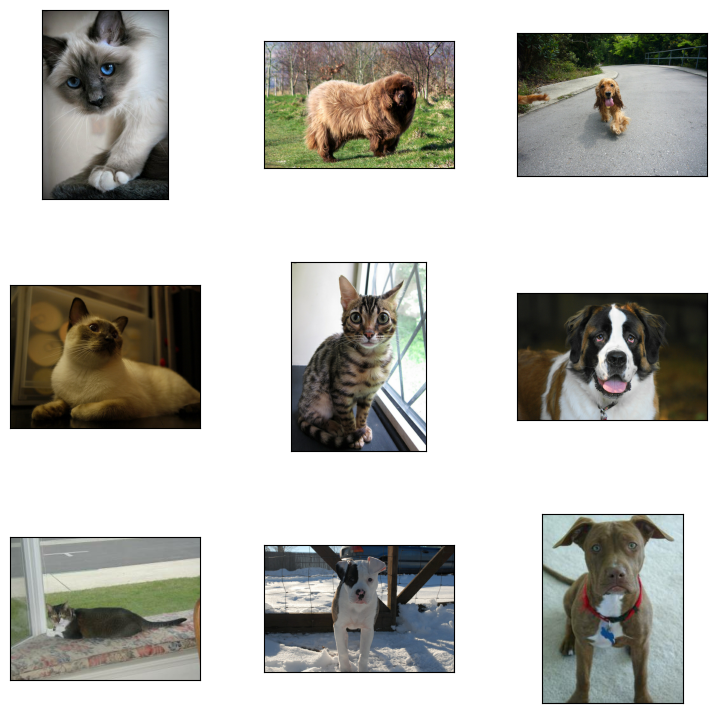

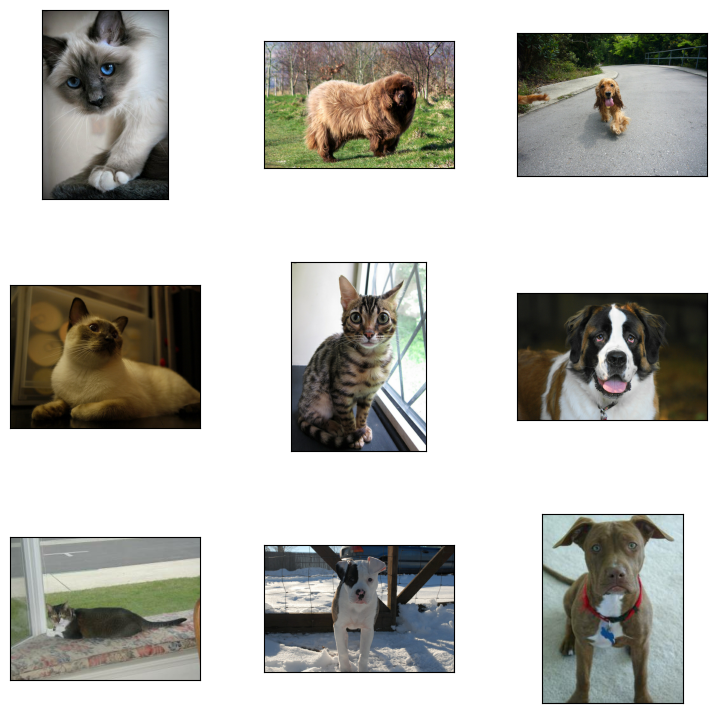

In [ ]:
tfds.show_examples(train_raw, ds_info, image_key='image')

___
## (3) Understanding the dataset
#### Retrieve relevant counts to better understand the dataset we will be working on

In [ ]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

Number of classes: 37


In [ ]:
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


In [ ]:
def get_value_counts(ds):
    label_list = []
    for images, labels in ds:
        label_list.append(labels.numpy())
    label_counts = pd.Series(label_list).value_counts(sort=True)

    print(label_counts)

In [ ]:
get_value_counts(train_raw)

19    96
20    95
21    94
26    94
18    94
24    93
13    93
23    93
35    92
14    92
2     92
5     92
4     91
31    91
22    91
8     90
36    90
10    90
34    90
27    89
3     88
1     88
30    88
16    88
29    88
0     88
9     88
28    87
15    87
17    86
32    86
12    86
25    86
33    85
7     85
6     84
11    82
Name: count, dtype: int64


In [ ]:
get_value_counts(val_raw)

6     16
33    15
17    14
25    14
28    13
15    13
32    13
3     12
0     12
1     12
30    12
16    12
9     12
29    12
7     11
27    11
11    11
10    10
8     10
34    10
36    10
12    10
4      9
31     9
2      8
14     8
35     8
5      8
23     7
13     7
24     7
18     6
21     6
26     6
22     5
20     5
19     4
Name: count, dtype: int64


In [ ]:
# Function to obtain the name for the label integer
get_label_name = ds_info.features['label'].int2str

In [ ]:
# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

Image shape:  (333, 500, 3)


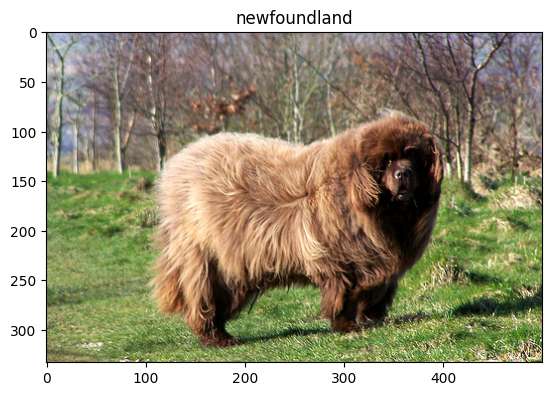

In [ ]:
view_single_image(train_raw)

___
## (4) Data Preparation

### (i) Image Resizing
- Because the raw images come in different sizes, we want to resize them to the same size before parsing them into the neural network later
- More specifically, we want both the length and width to be 224 pixels (which is what ResNet50 expects)

In [ ]:
IMG_SIZE_RESNET50 = 224

train_ds_resnet = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_RESNET50, IMG_SIZE_RESNET50)), y))
val_ds_resnet = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_RESNET50, IMG_SIZE_RESNET50)), y))
test_ds_resnet = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_RESNET50, IMG_SIZE_RESNET50)), y))

In [ ]:
IMG_SIZE_INCEPTION = 299

train_ds_inception = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION)), y))
val_ds_inception = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION)), y))
test_ds_inception = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION)), y))

In [ ]:
IMG_SIZE_MOBILENET = 224

train_ds_mobilenet = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_MOBILENET, IMG_SIZE_MOBILENET)), y))
val_ds_mobilenet = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_MOBILENET, IMG_SIZE_MOBILENET)), y))
test_ds_mobilenet = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_MOBILENET, IMG_SIZE_MOBILENET)), y))

___
### (ii) Label One-hot Encoding
- There are 37 classes (i.e. pet breeds) in the dataset that we are using for multi-class image classification
- As such, we proceed to one-hot encode the labels so that we get a output vector of length 37

In [ ]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
train_ds_resnet = train_ds_resnet.map(one_hot_encode)
val_ds_resnet = val_ds_resnet.map(one_hot_encode)
test_ds_resnet = test_ds_resnet.map(one_hot_encode)

In [ ]:
train_ds_inception = train_ds_inception.map(one_hot_encode)
val_ds_inception = val_ds_inception.map(one_hot_encode)
test_ds_inception = test_ds_inception.map(one_hot_encode)

In [ ]:
train_ds_mobilenet = train_ds_mobilenet.map(one_hot_encode)
val_ds_mobilenet = val_ds_mobilenet.map(one_hot_encode)
test_ds_mobilenet = test_ds_mobilenet.map(one_hot_encode)

#### Let's have a look at what our dataset object looks like currently

In [ ]:
train_ds_resnet

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(37,), dtype=tf.float32, name=None))>

In [ ]:
train_ds_inception

<_MapDataset element_spec=(TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(37,), dtype=tf.float32, name=None))>

In [ ]:
train_ds_mobilenet

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(37,), dtype=tf.float32, name=None))>

From the printout, we can see that each dataset object (i.e., `train_ds`, `val_ds`, and `test_ds`) has two components each:
- Images of shape (224,224,3)
- Label vector of shape (37,)

The values in each component has also been casted to a float data type, which is what we want for the deep learning model later. Another point to keep in mind is that these objects are **generators**, meaning that they only return one set of image and label when we iterate over it one value at a time.

### (iii) Image (Data) Augmentation
- Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.
- The purpose is to reduce model overfitting by exposing our model to variations and small transformations in the original data. It is useful especially when we do not have a large dataset.
- Note that the image augmentation needs to be realistic. For example, flipping car images upside down may not be the best choice here since we expect most cars to be photographed with the wheels on the ground (barring severe accidents)
- To perform data augmentation, we use the Keras preprocessing layers API. Each type of image augmentation that we want to introduce is defined as a layer within a Keras Sequential class.
- We will only perform a random horizontal flip for the images for the sake of simplicity, though do note that there is a wide range of different augmentations available to us: https://keras.io/api/layers/preprocessing_layers/image_augmentation/

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

#### View effects of augmentation

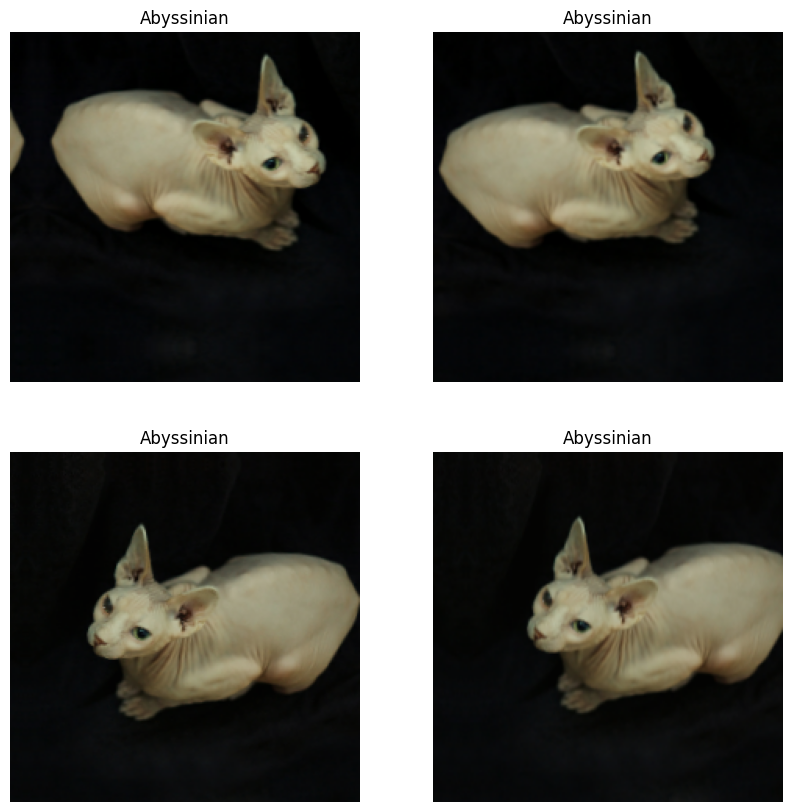

In [ ]:
for image, label in train_ds_resnet.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

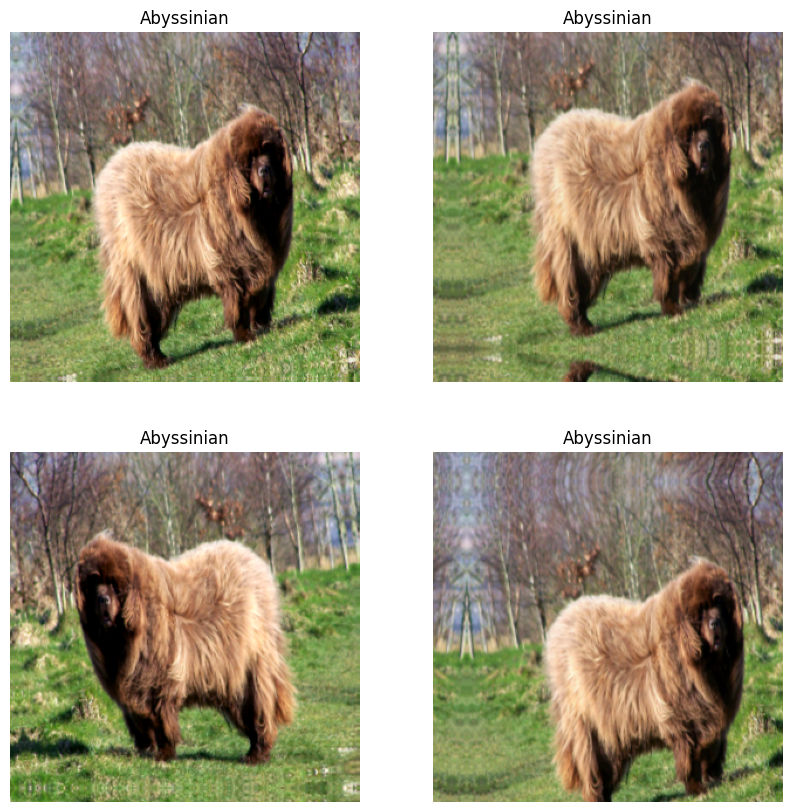

In [ ]:
for image, label in train_ds_inception.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

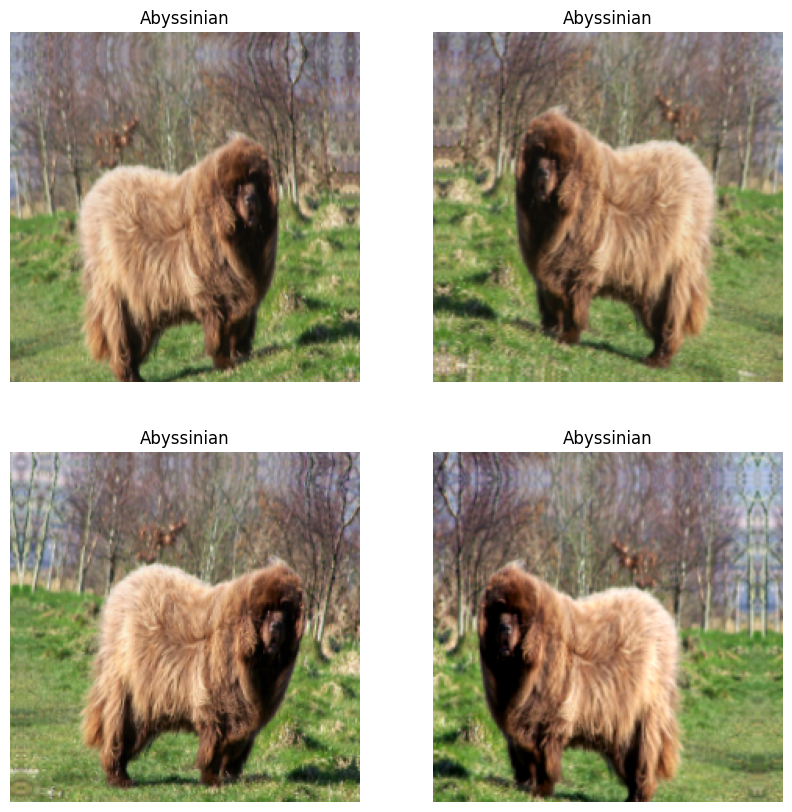

In [ ]:
for image, label in train_ds_mobilenet.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

### (iv) Batching and Prefetching
- We can batch the data and use prefetching to optimize loading speed and model efficiency
- A batch size of 32 is a good value to start with
- The number of elements to prefetch can be automatically determined by making use of `tf.data.AUTOTUNE`, which prompt the runtime to tune the value dynamically for us.

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds_resnet = train_ds_resnet.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds_resnet = val_ds_resnet.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds_resnet = test_ds_resnet.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds_inception = train_ds_inception.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds_inception = val_ds_inception.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds_inception = test_ds_inception.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds_mobilenet = train_ds_mobilenet.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds_mobilenet = val_ds_mobilenet.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds_mobilenet = test_ds_mobilenet.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

- After batching and prefetching, note that the dataset object has been transformed such that the earlier functions to view images will no longer work
- Caching (with `.cache()`) is another way to speed up the process, where we store dataset either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. However, note that this can cause RAM limit issues in the free version of Google Colab, thus caching has been excluded in this step.

___
## (5) Model Setup
- With the data prepared, it is time to define the model we want to use for the multi-class classification task
- For this task, we will make use of transfer learning so that we do not need to train a deep learning model from scratch (which is tedious and requires plenty of data)
- Keras comes with a host of pre-trained models that we can leverage for transfer learning: https://keras.io/api/applications/
- We will be using ResNet50V2 given that it offers a good balance of accuracy, size, and speed
- More information about ResNet can be found here: https://keras.io/api/applications/resnet/

### (i) Setup base model
- Instantiate a ResNet50V2 object from `keras.applications`
- Set `include_top=False` because we want to remove the top layers of the pre-trained model (that was trained to classify ImageNet) and introduce our own final layers for our specific car image classification task
- Keep the weights as `imagenet`, because we want to keep the ResNet weights that were trained on the ImageNet dataset
- This process is known as transfer learning, because we use the pre-trained ImageNet weights

In [ ]:
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE_RESNET50, IMG_SIZE_RESNET50, 3)
                            )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
inception_v3 = keras.applications.InceptionV3(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION, 3)
                            )

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
mobilenet_v2 = keras.applications.MobileNetV2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE_MOBILENET, IMG_SIZE_MOBILENET, 3)
                            )

9406464/9406464 [==============================] - 0s 0us/step


### (ii) Freeze pre-trained weights of the base model
- When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [ ]:
# Freeze the base_model
base_model.trainable = False
inception_v3.trainable = False
mobilenet_v2.trainable = False

### (iii) Modify inputs
- We pre-process the inputs (i.e., images) so that they are compatible with what the pre-trained ResNet50v2 architecture expects

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE_RESNET50, IMG_SIZE_RESNET50, 3))
x_resnet = data_augmentation(inputs)
x_resnet = keras.applications.resnet_v2.preprocess_input(x_resnet)
x_resnet = base_model(x_resnet, training=False)

In [ ]:
# Create new model on top
inputs_inception = keras.Input(shape=(IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION, 3))
x_inception = data_augmentation(inputs_inception)
x_inception = keras.applications.inception_v3.preprocess_input(x_inception)
x_inception = inception_v3(x_inception, training=False)

In [ ]:
# Create new model on top
inputs_mobilenet = keras.Input(shape=(IMG_SIZE_MOBILENET, IMG_SIZE_MOBILENET, 3))
x_mobilenet = data_augmentation(inputs_mobilenet)
x_mobilenet = keras.applications.mobilenet_v3.preprocess_input(x_mobilenet)
x_mobilenet = mobilenet_v2(x_mobilenet, training=False)

- Although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.
- This means that the batch normalization layers inside will not update their batch statistics (i.e., mean and variance)
- If they did, they would wreak havoc on the representations learned by the model so far because the training done would have been undone.

### (iv) Rebuild top layers
- Given that we have removed the top ImageNet classifier layer of ResNet50V2, we can now build a custom top layer that is specific to our image classification task i.e., classify an image based on the 37 different pet breeds types.

In [ ]:
# Rebuild top layers for RESNET50 model
x_resnet = layers.GlobalAveragePooling2D()(x_resnet)
x_resnet = layers.BatchNormalization()(x_resnet)
x_resnet = layers.Dropout(0.2)(x_resnet)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x_resnet)

model_resnet = keras.Model(inputs, outputs)

In [ ]:
# Rebuild top layers for Inception V3 model
x_inception = layers.GlobalAveragePooling2D()(x_inception)
x_inception = layers.BatchNormalization()(x_inception)
x_inception = layers.Dropout(0.2)(x_inception)  # Regularize with dropout

outputs_inception = layers.Dense(num_classes, activation="softmax", name="pred")(x_inception)

model_inception = keras.Model(inputs_inception, outputs_inception)

In [ ]:
# Rebuild top layers for MobileNetV2 model
x_mobilenet = layers.GlobalAveragePooling2D()(x_mobilenet)
x_mobilenet = layers.BatchNormalization()(x_mobilenet)
x_mobilenet = layers.Dropout(0.2)(x_mobilenet)  # Regularize with dropout

outputs_mobilenet = layers.Dense(num_classes, activation="softmax", name="pred")(x_mobilenet)

model_mobilenet = keras.Model(inputs_mobilenet, outputs_mobilenet)

#### Display model summary

In [ ]:
model_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
model_inception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

In [ ]:
model_mobilenet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_96 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                           

#### Compile model
- Utilize the commonly used Adam optimizer (leave the learning rate as default)
- Since it is a multi-class classification, we will use categorical cross entropy and categorical accuracy as our loss and performance metric respectively

In [ ]:
model_resnet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
model_inception.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
model_mobilenet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Include early stopping
- Prevent overfitting

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

___
## (6) Model Training

#### Fit model
- Ensure that the Google Colab runtime using GPU hardware accelerator
- Fit the model over the training dataset for 15 epochs
- Store the training output as a variable called `history`

In [ ]:
EPOCHS = 15

history = model_resnet.fit(train_ds_resnet, epochs=EPOCHS, validation_data=val_ds_resnet, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/15
103/103 [==============================] - 680s 7s/step - loss: 1.2587 - categorical_accuracy: 0.6484 - val_loss: 0.6073 - val_categorical_accuracy: 0.8210
Epoch 2/15
103/103 [==============================] - 667s 6s/step - loss: 0.3880 - categorical_accuracy: 0.8735 - val_loss: 0.4755 - val_categorical_accuracy: 0.8438
Epoch 3/15
103/103 [==============================] - 668s 6s/step - loss: 0.2423 - categorical_accuracy: 0.9220 - val_loss: 0.4423 - val_categorical_accuracy: 0.8523
Epoch 4/15
103/103 [==============================] - 664s 6s/step - loss: 0.2075 - categorical_accuracy: 0.9345 - val_loss: 0.4637 - val_categorical_accuracy: 0.8693
Epoch 5/15
103/103 [==============================] - 670s 7s/step - loss: 0.1655 - categorical_accuracy: 0.9439 - val_loss: 0.4610 - val_categorical_accuracy: 0.8580
Epoch 6/15
 44/103 [===========>..................] - ETA: 5:33 - loss: 0.1241 - categorical_accuracy: 0.9602

In [ ]:
EPOCHS = 15

history = model_inception.fit(train_ds_inception, epochs=EPOCHS, validation_data=val_ds_inception, verbose=1,
                    callbacks =[earlystopping])

In [ ]:
EPOCHS = 25

history = model_mobilenet.fit(train_ds_mobilenet, epochs=EPOCHS, validation_data=val_ds_mobilenet, verbose=1,
                    callbacks =[earlystopping])

#### Plot the accuracy of training and validation sets over epochs

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

___
## (7) Model Evaluation

In [ ]:
preds_resent = model_resnet.predict(test_ds_resnet)

In [ ]:
preds_inception = model_inception.predict(test_ds_inception)

In [ ]:
preds_mobilenet = model_mobilenet.predict(test_ds_mobilenet)

#### Evaluate model on test dataset

In [ ]:
result_resnet = model_resnet.evaluate(test_ds_resnet)

In [ ]:
result_inception = model_inception.evaluate(test_ds_inception)

In [ ]:
result_mobilenet = model_mobilenet.evaluate(test_ds_mobilenet)

#### Display results

In [ ]:
dict(zip(model_resnet.metrics_names, result_resnet))

In [ ]:
dict(zip(model_inception.metrics_names, result_inception))

In [ ]:
dict(zip(model_mobilenet.metrics_names, result_mobilenet))

___
## (8) Finetune Model (OPTIONAL)
- Once our model has converged on the new data, we can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate (e.g., 0.0001)
- This is an optional last step that can potentially give us incremental improvements. However, it can also potentially lead to quick overfitting.

#### Unfreeze base model
- We only want to unfreeze top 15 layers that are NOT batch normalization layers

In [ ]:
for layer in model_resnet.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

NameError: name 'model_resnet' is not defined

#### Recompile model
- This step needs to be done to take into account the change above, where we set the `trainable` attribute of the base model layers to True

In [ ]:
model_resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Retrain model
- Using fewer epochs given the high risk of overfitting in fine-tuning

In [ ]:
EPOCHS = 5

history_2 = model_resnet.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks =[earlystopping])

#### Display fine-tuned model results

In [ ]:
result_2 = model.evaluate(test_ds)

dict(zip(model.metrics_names, result_2))

We can see that the final step of unfreezing several layers of the model has indeed given the model performance a good boost.